In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

In [40]:
import pandas as pd
import os,sys
from pathlib import Path
import json 
import logging
logging.basicConfig(format='%(asctime)s %(levelname)-7s %(message)s',
                    stream=sys.stderr, level=logging.INFO)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.INFO)


#General ML 
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, silhouette_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn import svm



#In-house Module Imports
from config import Configuration 
from datasets import EclipseSampledDataset, VoltaSampledDataset
from utils import *

from modules.models import BaseAutoencoder
from modules.models_helper import *

In [4]:
def readModelConfig(conf, exp_name,cv_index,model_name,system):
    """Reads saved config file and returns as a dictionary"""
    
    import math    
    #config_path = Path('/projectnb/peaclab-mon/aksar/clustering_experiments/{system}/{exp_name}/CV_{cv_index}/{model_name}/model_config.csv'.format(system=system,exp_name=exp_name,cv_index=cv_index,model_name=model_name))
    config_path = conf['model_config_dir'] / "model_config.csv" #/ f"{model_name}/model_config.csv" 
    print(config_path)
    
    conf = {}
    try:
        conf_csv = pd.read_csv(config_path)
    except:
        logging.info("Config.csv doesn't exist")
    

    for column in conf_csv.columns:
        if isinstance(conf_csv[column][0],str):
            if 'dir' in column:
                conf[column] = Path(conf_csv[column][0])
            else:
                conf[column] = conf_csv[column][0]
                
        #FIXME: Find a generic comparison for integers
        elif isinstance(conf_csv[column][0],np.int64):
                conf[column] = conf_csv[column][0]  
                
        elif isinstance(conf_csv[column][0],np.bool_):
                conf[column] = conf_csv[column][0]                  
        else:
            if math.isnan(conf_csv[column][0]):
                conf[column] = None
        
    return conf

In [180]:
class Autoencoder(Model):
    def __init__(self, params):
        super(Autoencoder, self).__init__()
        self.params = params
        
        self.encoder = tf.keras.Sequential([
          #layers.Dropout(params['dropout']),                        
          #layers.Dense(1000, activation=params['hidden_acts']),
          layers.Dense(params['latent_dim'], activation=params['latent_activation'],name='code')
        ],name='Encoder')
        
        self.decoder = tf.keras.Sequential([
          #layers.Dense(1000, activation=params['hidden_acts']),                        
          #layers.Dropout(params['dropout']),                        
          layers.Dense(x_dim, activation='linear'),            
        ],name='Decoder')

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def get_config(self):
        return {
            "model_name": self.params['model_name'],
            #Layer related stuff
            "latent_dim": self.params['latent_dim'],
            "latent_activation": self.params['latent_activation'],
            "dropout_rate": self.params['dropout'],
            "regularizer": self.params['regularizer'],            
            "regularization_rate": self.params['regularization_rate'],                        
            #Compilation related stuff            
            "optimizer": self.optimizer,
            "loss": self.loss,
            #Training
            "epochs": self.params['epochs']
        }    

In [7]:
user = "aksar"
logging.warning(f'Are you sure that you are: {user}?')

2022-05-16 03:16:51,711 WARNING Are you sure that you are: aksar?


In [181]:
MODEL_CONFIG = "proctor_exp_1_active_learning"  # change this
SYSTEM = 'volta'  # volta or eclipse
FE_NAME = 'tsfresh' #tsfresh, or mvts => It will set the EXP_NAME. Be careful. 
NUM_FEATURE = 250  # example: 250 ,2000, 4000
classifier_name = 'proctor'
query_strategy = "random"  # "uncertainty", "margin", "entropy", "random", "equal_app"
CV_INDEX = 0  # it can be integer value within the range 0 1 2 3 4
repeat_num = 0
query_size = 250

In [182]:
#Constants
FS_NAME = "CHI"
method = "baseline" if (query_strategy == 'random' or query_strategy == 'equal_app')  else "active_learning"
num_samples_per_pair = 1

if SYSTEM == 'volta':
    OUTPUT_DIR = f'/projectnb/peaclab-mon/{user}/active_learning_experiments'
elif SYSTEM == 'eclipse':    
    OUTPUT_DIR = f'/projectnb/peaclab-mon/{user}/active_learning_experiments_final_hdfs'
    
EXP_NAME = f'{FE_NAME}_experiments'
FEATURE_SELECTION = False
SCALER = 'None' #For now, do the scaling inside the notebook, then you can move that to the class function

logging.warning('Results will be generated in {}, double check please!'.format(MODEL_CONFIG))

2022-05-16 05:15:04,047 WARNING Results will be generated in proctor_exp_1_active_learning, double check please!


In [183]:
conf = Configuration(ipython=True,
                     overrides={
                         'output_dir': Path(OUTPUT_DIR), #change
                         'system' : SYSTEM,
                         'exp_name':EXP_NAME,                                                  
                         'cv_fold':CV_INDEX, 
                         'model_config': MODEL_CONFIG,
                     })

with open(str(conf['experiment_dir']) + '/anom_dict.json') as f:
    ANOM_DICT = json.load(f)
with open(str(conf['experiment_dir']) + '/app_dict.json') as f:
    APP_DICT = json.load(f)    
    
APP_REVERSE_DICT = {}
for app_name, app_encoding in APP_DICT.items():
    APP_REVERSE_DICT[app_encoding] = app_name    

ANOM_REVERSE_DICT = {}
for anom_name, anom_encoding in ANOM_DICT.items():
    ANOM_REVERSE_DICT[anom_encoding] = anom_name        

2022-05-16 05:15:04,348 WARNING You set windowing False, but you are trying to define window_size parameter, it is automatically set to 0. Please double check.
2022-05-16 05:15:04,348 INFO    Setting directory names
2022-05-16 05:15:04,352 INFO    Model config folder already exists, be careful, otherwise it will overwrite!
2022-05-16 05:15:04,353 INFO    Saving configuration as CSV


# The configuration used for this run:
# {'cv_fold': 0,
#  'exp_name': 'tsfresh_experiments',
#  'experiment_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments'),
#  'feature_extract': False,
#  'feature_select': False,
#  'hdf_data_path': PosixPath('/projectnb/peaclab-mon/aksar/datasets/tpds_data_hdfs'),
#  'metadata_path': None,
#  'model_config': 'proctor_exp_1_active_learning',
#  'model_config_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_0/proctor_exp_1_active_learning'),
#  'model_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_0/proctor_exp_1_active_learning/model'),
#  'num_split': 5,
#  'operation': 'read',
#  'output_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta'),
#  'plots_dir': PosixPath('/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_0/proct

In [184]:
if SYSTEM == 'eclipse':
    eclipseDataset = EclipseSampledDataset(conf)
    train_data, train_label, test_data, test_label = eclipseDataset.load_dataset(scaler=SCALER,
                                                                                 cv_fold=CV_INDEX,
                                                                                 borghesi=False, 
                                                                                 mvts=True if FE_NAME == 'mvts' else False, 
                                                                                 tsfresh=True if FE_NAME == 'tsfresh' else False)

elif SYSTEM == 'volta':
    voltaDataset = VoltaSampledDataset(conf)
    train_data, train_label, test_data, test_label = voltaDataset.load_dataset(scaler=SCALER,
                                                                               cv_fold=CV_INDEX,
                                                                               borghesi=False,
                                                                               mvts=True if FE_NAME == 'mvts' else False,
                                                                               tsfresh=True if FE_NAME == 'tsfresh' else False)

assert list(train_data.index) == list(train_label.index) #check the order of the labels     
assert list(test_data.index) == list(test_label.index) #check the order of the labels    

if FEATURE_SELECTION:
    selected_features = pd.read_csv(conf['experiment_dir'] / 'selected_features.csv')
    train_data = train_data[list(selected_features['0'].values)]
    test_data = test_data[list(selected_features['0'].values)]
    
train_label['anom_names'] = train_label.apply(lambda x: ANOM_REVERSE_DICT[x['anom']], axis=1)
train_label['app_names']=train_label['app'].apply(lambda x: APP_REVERSE_DICT[x])
test_label['anom_names'] = test_label.apply(lambda x: ANOM_REVERSE_DICT[x['anom']], axis=1)
test_label['app_names']=test_label['app'].apply(lambda x: APP_REVERSE_DICT[x])

all_data = pd.concat([train_data, test_data])
all_data = all_data.dropna(axis=1, how='any')
all_label = pd.concat([train_label,test_label])

train_data = all_data.loc[train_label.index]
test_data = all_data.loc[test_label.index]
    
logging.info("Train data shape %s",train_data.shape)
logging.info("Train label shape %s",train_label.shape)
logging.info("Test data shape %s",test_data.shape)  
logging.info("Test label shape %s",test_label.shape)

logging.info("Train data label dist: \n%s",train_label['anom'].value_counts())
logging.info("Test data label dist: \n%s",test_label['anom'].value_counts())  

2022-05-16 05:15:04,884 INFO    BaseDataset Class Initialization
2022-05-16 05:15:04,884 INFO    HPCDataset Class Initialization
2022-05-16 05:15:04,885 INFO    VoltaSampledDataset Class Initialization
2022-05-16 05:16:02,236 INFO    Train data shape (6326, 102311)
2022-05-16 05:16:02,238 INFO    Train label shape (6326, 2)
2022-05-16 05:16:02,238 INFO    Test data shape (14589, 102311)
2022-05-16 05:16:02,239 INFO    Test label shape (14589, 2)
2022-05-16 05:16:02,240 WARNING Beware that no scaling method is applied
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

2022-05-16 05:16:32,688 INFO    Train data shape (6326, 99169)
2022-05-16 05:16:32,689 INFO    Train label shape (6326, 4)
202

In [185]:
orig_train_data = train_data.copy()
orig_test_data = test_data.copy()

In [186]:
# train_data = orig_train_data
# test_data = orig_test_data
# print(len(train_data.columns))

In [187]:
SCALER = 'MinMax'

if SCALER == 'MinMax':
    
    minmax_scaler = MinMaxScaler().fit(train_data)
    train_data = pd.DataFrame(minmax_scaler.transform(train_data),columns=train_data.columns,index=train_data.index)
    test_data = pd.DataFrame(minmax_scaler.transform(test_data),columns=test_data.columns,index=test_data.index)
    
elif SCALER == 'Standard':
    
    # Standardize data (per feature Z-normalization, i.e. zero-mean and unit variance)        
    scaler = StandardScaler().fit(train_data)
    train_data = pd.DataFrame(scaler.transform(train_data),columns=train_data.columns,index=train_data.index)
    test_data = pd.DataFrame(scaler.transform(test_data),columns=test_data.columns,index=test_data.index)  
    
#Implement new feature selection strategies below
if FS_NAME == 'CHI':
    
    selector = SelectKBest(chi2, k=NUM_FEATURE)
    selector.fit(train_data,train_label['anom'])
    train_data = train_data[train_data.columns[selector.get_support(indices=True)]]
    selected_columns = train_data.columns
    test_data = test_data[test_data.columns & selected_columns]
    
elif FS_NAME == 'TSFRESH':
    logging.warning("NUM_FEATURE parameter will be overwritten by the automatic selection process")
    
    y_train = train_label['anom']
    X_train = train_data

    relevant_features = set()

    for label in y_train.unique():
        y_train_binary = y_train == label
        X_train_filtered = tsfresh.select_features(X_train, y_train_binary)
        print("Number of relevant features for class {}: {}/{}".format(label, X_train_filtered.shape[1], X_train.shape[1]))
        relevant_features = relevant_features.union(set(X_train_filtered.columns))    
    train_data = train_data[relevant_features]
    test_data = test_data[relevant_features]
    NUM_FEATURE = len(relevant_features)
    
elif FS_NAME == 'NONE':
    logging.info("No feature selection strategy is specified, will be using all features")
    NUM_FEATURE = len(train_data.columns)
    
logging.info(train_data.shape)
logging.info(test_data.shape)    

2022-05-16 05:17:11,481 INFO    (6326, 250)
2022-05-16 05:17:11,482 INFO    (14589, 250)


In [188]:
#Read the node_ids considered labeled
labeled_train_label = pd.read_csv(conf['experiment_dir'] / f'CV_{CV_INDEX}'/ f'labeled_train_label_{num_samples_per_pair}.csv', index_col=['node_id'])
labeled_test_label = pd.read_csv(conf['experiment_dir'] / f'CV_{CV_INDEX}'/ f'labeled_test_label_{num_samples_per_pair}.csv', index_col=['node_id'])
node_indices_labeled = list(labeled_train_label['anom'].index.values)

logging.info("Labeled data label dist: \n%s",labeled_train_label['anom'].value_counts())
logging.info("Unlabeled data label dist: \n%s",labeled_test_label['anom'].value_counts())

#Set a new column for label status
node_indices_unlabeled = []
for node in train_label.index:
    if node not in node_indices_labeled:
        node_indices_unlabeled.append(node)
        
train_label['label_status'] = train_label['anom'] # for the full data case
train_label['label_status'] = np.where(train_label.index.get_level_values('node_id').isin(node_indices_unlabeled), -1,train_label['label_status'])

2022-05-16 05:17:11,546 INFO    Labeled data label dist: 
2    12
4    11
3    11
1    11
0    11
Name: anom, dtype: int64
2022-05-16 05:17:11,548 INFO    Unlabeled data label dist: 
0    5683
4     148
2     147
1     147
3     145
Name: anom, dtype: int64


In [189]:
#initial_labeled_pool contains one sample from each application anomaly pair
initial_labeled_pool = train_label[(train_label['label_status'] != -1)]

#Active learning or random sampling will be querying from the same pool
initial_unlabeled_pool = train_label[(train_label['label_status'] == -1)]

In [190]:
params = {}

#Compile related

params['loss'] = 'mse'

params['optimizer'] = 'adadelta'
params['learning_rate'] = 1e-3

#Layer related
params['dropout'] = 0 #This will add dropout after layers
params['regularizer'] = None
params['regularization_rate'] = None

params['hidden_layers'] = []
params['hidden_acts'] = 'relu'

params['latent_dim'] =  2000
params['latent_activation'] = 'relu' #change the activation of the code layer

#Training related
params['epochs'] = 10

if params['optimizer'] == 'adam':
    opt = optimizers.Adam(learning_rate=params['learning_rate'])
elif params['optimizer'] == 'adadelta':
    opt = optimizers.Adadelta(learning_rate=params['learning_rate'])
elif params['optimizer'] == 'sgd':
    opt = optimizers.SGD(learning_rate=params['learning_rate'])


if params['loss'] == 'mse':
    selected_loss = losses.MeanSquaredError()
elif params['loss'] == 'mae':
    selected_loss = losses.MeanAbsoluteError()
    
params['model_name'] = f"dae_{params['latent_dim']}_{params['epochs']}_{params['latent_activation']}"    

In [191]:
logging.info("Train data shape %s",train_data.shape)
logging.info("Train label shape %s",train_label.shape)

2022-05-16 05:17:11,682 INFO    Train data shape (6326, 250)
2022-05-16 05:17:11,682 INFO    Train label shape (6326, 5)


Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
code (Dense)                 (5619, 2000)              502000    
Total params: 502,000
Trainable params: 502,000
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (5619, 250)               500250    
Total params: 500,250
Trainable params: 500,250
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
141/141 [==============================] - 1s 3ms/step - loss: 0.0386 - val_loss: 0.0377
Epoch 2/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0379 - val_loss: 0.0371
Epoch 3/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0373 - val_loss: 0

2022-05-16 04:57:19,068 INFO    Assets written to: /projectnb/peaclab-mon/aksar/active_learning_experiments_final_hdfs/eclipse/mvts_experiments/CV_0/proctor_exp_1_active_learning/model/dae_2000_10_relu/assets
2022-05-16 04:57:19,093 INFO    Model saved!


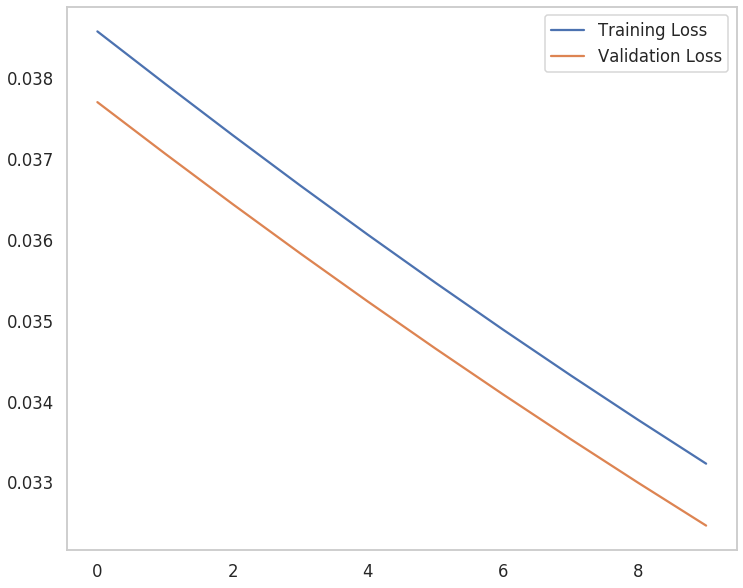

In [171]:
#BUILD AE

TRAIN_DATA = train_data.values

x_dim = TRAIN_DATA.shape[1]

autoencoder = Autoencoder(params)       

autoencoder.compile(optimizer=opt, loss=selected_loss)
autoencoder.build(TRAIN_DATA.shape) 
autoencoder.encoder.summary()
autoencoder.decoder.summary()
autoencoder.get_config()    

es = EarlyStopping(monitor='val_loss', 
                                    verbose=1,
                                    patience=10,
                                    mode='min',
                                    restore_best_weights=True)

history = autoencoder.fit(train_data.values, train_data.values,
                epochs=params['epochs'],
                shuffle=True,
                callbacks =[
                              es  
                            ],
                validation_split = 0.2,
                )

plt.plot(history.history["loss"], label="Training Loss")
if not history.history["val_loss"] is None:
    plt.plot(history.history["val_loss"], label="Validation Loss")
    
plt.legend()
plt.show

autoencoder.save(str(conf['model_dir'] / (params['model_name'])))
logging.info("Model saved!")    

### Train the supervised part

In [192]:
MODEL_NAME = MODEL_CONFIG

TOPOLOGY_NAME = params["model_name"]
STACKED = False #Set this when loading a stacked AE

FEATURE_SELECTION = False
REPEAT_SUPERVISED = 1
PERCENTAGE = 0

model_config = readModelConfig(conf,exp_name=EXP_NAME,cv_index=CV_INDEX,model_name=TOPOLOGY_NAME,system=SYSTEM)

/projectnb/peaclab-mon/aksar/active_learning_experiments/volta/tsfresh_experiments/CV_0/proctor_exp_1_active_learning/model_config.csv


In [193]:
#Convert test data to array format
assert list(test_label.index) == list(test_data.index.get_level_values('node_id')) 
test_true_data = test_data.values 
#test_true_data_fs = test_data[list(selected_features['0'].values)] 
test_true_label = test_label['anom'].values 

#Training data with feature selection
#train_data_fs = train_data[list(selected_features['0'].values)]
X_DIM = train_data.shape[1]

In [194]:
#initial_labeled_pool contains one sample from each application anomaly pair
initial_labeled_pool = train_label[(train_label['label_status'] != -1)]

#Active learning or random sampling will be querying from the same pool
initial_unlabeled_pool = train_label[(train_label['label_status'] == -1)]

In [199]:
def runMultipleTrainTestsProctorScikit(name,model_config,
                                       topology,X_train,y_train,X_test,y_test,
                                       repeat,cv_index,size,multimodal=True,stacked=False):
      
                                      
        macro_fscore = 0
        weight_fscore = 0
        miss_rate = 0
        alarm_rate = 0
        score_dict = {}
        
        #It means loading a full autoencoder
        if not stacked:
            reconstructedModel = LoadModel(model_config,topology)
            reconstructedModel = reconstructedModel.encoder
        else:
            reconstructedModel = LoadModel(model_config,topology)
                
        #Test data is constant 
        hidden_test = reconstructedModel.predict(X_test)             
                
        param_grid = {'C': [0.1,0.5, 1, 5, 10, 100, 1000],  
                      'tol': [1e-4, 1e-5, 1e-6,1e-7], 
                      'class_weight': [None, 'balanced'],
                      'max_iter': [1000,3000,5000,10000],
                      'penalty': ['l1','l2']
                      
                      }  
                    
        for i in range(repeat):                                    
            
            if multimodal:
                
                #Only anom vs normal            
                train_binary_label = y_train.copy()
                train_binary_label[train_binary_label != 0] = 1  
                                
                hidden_train_binary = reconstructedModel.predict(X_train)
                            
                
                ####Previous
                clf_binary = svm.LinearSVC(max_iter=10000,C=100)                 
                clf_binary.fit(hidden_train_binary, train_binary_label)                
                
                #Only anomalies
                anom_indices = np.where(y_train != 0)
                train_anom_label = y_train[anom_indices]
                train_anom_data = X_train[anom_indices]  
                
                hidden_train_anom = reconstructedModel.predict(train_anom_data)
                               
                clf_anom = svm.LinearSVC(max_iter=10000,C=100)    
                clf_anom.fit(hidden_train_anom, train_anom_label)                
                
                test_pred_label = filteredTestingProctorScikit(clf_binary,clf_anom,hidden_test)
            
            else:
                if name == 'aksar_svm':
                    hidden_train = reconstructedModel.predict(X_train)
                    
                    #clf = svm.LinearSVC(max_iter=10000,C=100)  
                    #clf = svm.LinearSVC()    
                    clf = svm.SVC()
                    clf.fit(hidden_train, y_train)                            
                    test_pred_label = clf.predict(hidden_test)
                    
                elif name == 'aksar_lr':      
                    
                    hidden_train = reconstructedModel.predict(X_train)
                    clf = LogisticRegression(random_state=1234,
                                                    dual=True,
                                                    penalty='l2',
                                                    solver='liblinear')                      
                    clf.fit(hidden_train, y_train)                            
                    test_pred_label = clf.predict(hidden_test)
                    
                elif name == 'aksar_svm-scale':      
                    hidden_train = reconstructedModel.predict(X_train)
                    clf = svm.SVC(C=1,kernel='rbf',probability=True)
                    clf.fit(hidden_train, y_train)                            
                    test_pred_label = clf.predict(hidden_test)                                                                                             
            
            score_report = classification_report(y_true=y_test, y_pred =test_pred_label,output_dict=True)
            logging.info("#############")
            logging.info(classification_report(y_true=y_test, y_pred =test_pred_label))
            logging.info("#############")            
            alarm_report = falseAnomRateCalc(y_test,test_pred_label)
            
            macro_fscore += score_report['macro avg']['f1-score']            
            weight_fscore += score_report['weighted avg']['f1-score']
            miss_rate += alarm_report['anom_miss_rate'] 
            alarm_rate += alarm_report['false_alarm_rate']
        
        
        score_dict['false_alarm_rate'] = alarm_rate / repeat
        score_dict['anom_miss_rate'] = miss_rate / repeat        
        score_dict['macro_fscore'] = macro_fscore / repeat
        score_dict['weight_fscore'] = weight_fscore / repeat
        
        
#         filename = f"test_Proctor-Kmeans-LogisticRegression-NoLP-NoTH_5_{size}_{cv_index}.json"
#         json_dump = json.dumps(score_dict)
#         f_json = open(model_config['results_dir'] / (filename),"w")
#         f_json.write(json_dump)
#         f_json.close() 
        
        return score_dict

In [203]:
step = 10 #Select 50 samples at a time

for repeat_num in range(0,10):

    macro_f1_scores = []
    anomaly_miss_rates = []
    false_alarm_rates = []
    
    
    temp_labeled_pool_labels = initial_labeled_pool.copy()
    temp_unlabeled_pool_labels = initial_unlabeled_pool.copy()

    logging.info("Temp Labeled data label dist: \n%s",temp_labeled_pool_labels['anom'].value_counts())
    logging.info("Temp Unlabeled data label dist: \n%s",temp_unlabeled_pool_labels['anom'].value_counts())    
    
    train_semisup_data = train_data.loc[temp_labeled_pool_labels.index]
    train_semisup_label = temp_labeled_pool_labels['anom'].values    
        
    temp_score_dict = runMultipleTrainTestsProctorScikit(      
                        'aksar_svm',
                        model_config,
                        TOPOLOGY_NAME,
                        train_semisup_data,
                        train_semisup_label,
                        test_true_data,
                        test_true_label,
                        REPEAT_SUPERVISED,
                        CV_INDEX,
                        num_samples_per_pair,                    
                        multimodal=False, 
                        stacked=STACKED)        


    macro_f1_scores.append(temp_score_dict['macro_fscore'])                                        
    false_alarm_rates.append(temp_score_dict['false_alarm_rate'])                                        
    anomaly_miss_rates.append(temp_score_dict['anom_miss_rate'])      


    for i in range(0,query_size,step):

        logging.info(f"Labeled Pool Size: {len(temp_labeled_pool_labels)};  Unlabeled Pool Size: {len(temp_unlabeled_pool_labels)} \n", )

        temp_selected_labels = temp_unlabeled_pool_labels.sample(step)
        temp_labeled_pool_labels = pd.concat([temp_labeled_pool_labels, temp_selected_labels])
        temp_unlabeled_pool_labels.drop(index=temp_selected_labels.index,inplace=True)

        logging.info("Temp Labeled data label dist: \n%s",temp_labeled_pool_labels['anom'].value_counts())
        logging.info("Temp Unlabeled data label dist: \n%s",temp_unlabeled_pool_labels['anom'].value_counts())

        train_semisup_data = train_data.loc[temp_labeled_pool_labels.index]
        train_semisup_label = temp_labeled_pool_labels['anom'].values


        temp_score_dict = runMultipleTrainTestsProctorScikit(      
                            'aksar_svm',
                            model_config,
                            TOPOLOGY_NAME,
                            train_semisup_data,
                            train_semisup_label,
                            test_true_data,
                            test_true_label,
                            REPEAT_SUPERVISED,
                            CV_INDEX,
                            num_samples_per_pair,                    
                            multimodal=False, 
                            stacked=STACKED)        


        macro_f1_scores.append(temp_score_dict['macro_fscore'])                                        
        false_alarm_rates.append(temp_score_dict['false_alarm_rate'])                                        
        anomaly_miss_rates.append(temp_score_dict['anom_miss_rate'])      
        
        scores = pd.DataFrame()

        for j in range(0,len(macro_f1_scores)):
            scores = scores.append({'query_iter':j*step,
                                    'macro_avg_f1_score':macro_f1_scores[j],
                                    'false_alarm_rate':false_alarm_rates[j],
                                    'anomaly_miss_rate':anomaly_miss_rates[j], 
                                    'repeat_num':repeat_num},
                                   ignore_index = True)


        scores['fold'] = CV_INDEX
        scores['method'] = method
        scores['query_strategy'] = query_strategy
        scores['model'] = "Proctor"
        scores['dataset'] = SYSTEM
        scores['fe'] = FE_NAME
        scores['feature_count'] = NUM_FEATURE   
        scores['query_size'] = query_size


        scores = scores.sort_values(by = ['query_iter']).reset_index(drop = True)

        train_app_names = "all"
        test_app_names = "all"

        filename = f"train:{train_app_names}#test:{test_app_names}#{FE_NAME}#{NUM_FEATURE}#{method}#{query_strategy}#{query_size}#Proctor#{repeat_num}.csv"
        scores.to_csv(Path(conf["results_dir"]) / filename)

        logging.info("Saving: %s", filename)                


2022-05-16 05:23:53,392 INFO    Temp Labeled data label dist: 
2    12
4    11
3    11
1    11
0    11
Name: anom, dtype: int64
2022-05-16 05:23:53,394 INFO    Temp Unlabeled data label dist: 
0    5683
4     148
2     147
1     147
3     145
Name: anom, dtype: int64
2022-05-16 05:23:53,396 INFO    Loading model!
2022-05-16 05:23:55,469 INFO    #############
2022-05-16 05:23:55,483 INFO                  precision    recall  f1-score   support

           0       0.98      1.00      0.99     13286
           1       0.99      0.70      0.82       332
           2       1.00      0.93      0.97       326
           3       1.00      1.00      1.00       324
           4       0.93      0.39      0.55       321

    accuracy                           0.98     14589
   macro avg       0.98      0.80      0.86     14589
weighted avg       0.98      0.98      0.97     14589

2022-05-16 05:23:55,483 INFO    #############
2022-05-16 05:23:55,484 INFO    Total misclassified normal runs: 9, Tota

2022-05-16 05:24:06,995 INFO    Labeled Pool Size: 106;  Unlabeled Pool Size: 6220 

2022-05-16 05:24:07,001 INFO    Temp Labeled data label dist: 
0    60
2    16
4    14
3    13
1    13
Name: anom, dtype: int64
2022-05-16 05:24:07,003 INFO    Temp Unlabeled data label dist: 
0    5634
1     145
4     145
3     143
2     143
Name: anom, dtype: int64
2022-05-16 05:24:07,005 INFO    Loading model!
2022-05-16 05:24:09,344 INFO    #############
2022-05-16 05:24:09,359 INFO                  precision    recall  f1-score   support

           0       0.99      1.00      0.99     13286
           1       0.95      0.95      0.95       332
           2       1.00      0.93      0.97       326
           3       1.00      1.00      1.00       324
           4       0.93      0.47      0.62       321

    accuracy                           0.98     14589
   macro avg       0.97      0.87      0.91     14589
weighted avg       0.98      0.98      0.98     14589

2022-05-16 05:24:09,359 INFO    #

2022-05-16 05:24:21,505 INFO    Total misclassified anom runs: 182, Total anom runs 1303 
2022-05-16 05:24:21,506 INFO    0.13967766692248657
2022-05-16 05:24:21,535 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#0.csv
2022-05-16 05:24:21,536 INFO    Labeled Pool Size: 166;  Unlabeled Pool Size: 6160 

2022-05-16 05:24:21,542 INFO    Temp Labeled data label dist: 
0    114
2     18
4     15
3     15
1     14
Name: anom, dtype: int64
2022-05-16 05:24:21,544 INFO    Temp Unlabeled data label dist: 
0    5580
1     144
4     144
3     141
2     141
Name: anom, dtype: int64
2022-05-16 05:24:21,546 INFO    Loading model!
2022-05-16 05:24:23,901 INFO    #############
2022-05-16 05:24:23,916 INFO                  precision    recall  f1-score   support

           0       0.99      1.00      0.99     13286
           1       0.95      0.97      0.96       332
           2       1.00      0.93      0.97       326
           3       1.00      1.00      1.00       324

2022-05-16 05:24:36,520 INFO    #############
2022-05-16 05:24:36,520 INFO    Total misclassified normal runs: 15, Total normal runs 13286 
2022-05-16 05:24:36,521 INFO    0.0011290079783230467
2022-05-16 05:24:36,521 INFO    Total misclassified anom runs: 181, Total anom runs 1303 
2022-05-16 05:24:36,522 INFO    0.13891020721412126
2022-05-16 05:24:36,562 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#0.csv
2022-05-16 05:24:36,563 INFO    Labeled Pool Size: 226;  Unlabeled Pool Size: 6100 

2022-05-16 05:24:36,569 INFO    Temp Labeled data label dist: 
0    166
2     20
4     18
3     18
1     14
Name: anom, dtype: int64
2022-05-16 05:24:36,571 INFO    Temp Unlabeled data label dist: 
0    5528
1     144
4     141
2     139
3     138
Name: anom, dtype: int64
2022-05-16 05:24:36,573 INFO    Loading model!
2022-05-16 05:24:39,229 INFO    #############
2022-05-16 05:24:39,243 INFO                  precision    recall  f1-score   support

           0       0.

2022-05-16 05:24:52,727 INFO    #############
2022-05-16 05:24:52,728 INFO    Total misclassified normal runs: 15, Total normal runs 13286 
2022-05-16 05:24:52,729 INFO    0.0011290079783230467
2022-05-16 05:24:52,729 INFO    Total misclassified anom runs: 174, Total anom runs 1303 
2022-05-16 05:24:52,730 INFO    0.1335379892555641
2022-05-16 05:24:52,778 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#0.csv
2022-05-16 05:24:52,778 INFO    Labeled Pool Size: 286;  Unlabeled Pool Size: 6040 

2022-05-16 05:24:52,784 INFO    Temp Labeled data label dist: 
0    223
2     23
4     18
3     18
1     14
Name: anom, dtype: int64
2022-05-16 05:24:52,786 INFO    Temp Unlabeled data label dist: 
0    5471
1     144
4     141
3     138
2     136
Name: anom, dtype: int64
2022-05-16 05:24:52,788 INFO    Loading model!
2022-05-16 05:24:55,354 INFO    #############
2022-05-16 05:24:55,369 INFO                  precision    recall  f1-score   support

           0       0.9

2022-05-16 05:25:06,840 INFO    #############
2022-05-16 05:25:06,841 INFO    Total misclassified normal runs: 10, Total normal runs 13286 
2022-05-16 05:25:06,842 INFO    0.0007526719855486979
2022-05-16 05:25:06,843 INFO    Total misclassified anom runs: 273, Total anom runs 1303 
2022-05-16 05:25:06,843 INFO    0.20951650038372985
2022-05-16 05:25:06,860 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#1.csv
2022-05-16 05:25:06,860 INFO    Labeled Pool Size: 86;  Unlabeled Pool Size: 6240 

2022-05-16 05:25:06,867 INFO    Temp Labeled data label dist: 
0    47
3    13
2    13
4    12
1    11
Name: anom, dtype: int64
2022-05-16 05:25:06,869 INFO    Temp Unlabeled data label dist: 
0    5647
1     147
4     147
2     146
3     143
Name: anom, dtype: int64
2022-05-16 05:25:06,871 INFO    Loading model!
2022-05-16 05:25:09,008 INFO    #############
2022-05-16 05:25:09,022 INFO                  precision    recall  f1-score   support

           0       0.98    

2022-05-16 05:25:20,519 INFO    #############
2022-05-16 05:25:20,520 INFO    Total misclassified normal runs: 14, Total normal runs 13286 
2022-05-16 05:25:20,520 INFO    0.001053740779768177
2022-05-16 05:25:20,521 INFO    Total misclassified anom runs: 195, Total anom runs 1303 
2022-05-16 05:25:20,522 INFO    0.1496546431312356
2022-05-16 05:25:20,548 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#1.csv
2022-05-16 05:25:20,549 INFO    Labeled Pool Size: 146;  Unlabeled Pool Size: 6180 

2022-05-16 05:25:20,555 INFO    Temp Labeled data label dist: 
0    104
2     15
3     13
4     12
1     12
Name: anom, dtype: int64
2022-05-16 05:25:20,557 INFO    Temp Unlabeled data label dist: 
0    5590
4     147
1     146
2     144
3     143
Name: anom, dtype: int64
2022-05-16 05:25:20,559 INFO    Loading model!
2022-05-16 05:25:22,712 INFO    #############
2022-05-16 05:25:22,727 INFO                  precision    recall  f1-score   support

           0       0.99

2022-05-16 05:25:34,127 INFO    #############
2022-05-16 05:25:34,128 INFO    Total misclassified normal runs: 14, Total normal runs 13286 
2022-05-16 05:25:34,128 INFO    0.001053740779768177
2022-05-16 05:25:34,129 INFO    Total misclassified anom runs: 189, Total anom runs 1303 
2022-05-16 05:25:34,129 INFO    0.14504988488104376
2022-05-16 05:25:34,167 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#1.csv
2022-05-16 05:25:34,168 INFO    Labeled Pool Size: 206;  Unlabeled Pool Size: 6120 

2022-05-16 05:25:34,174 INFO    Temp Labeled data label dist: 
0    157
2     16
3     15
4     14
1     14
Name: anom, dtype: int64
2022-05-16 05:25:34,176 INFO    Temp Unlabeled data label dist: 
0    5537
4     145
1     144
2     143
3     141
Name: anom, dtype: int64
2022-05-16 05:25:34,178 INFO    Loading model!
2022-05-16 05:25:36,426 INFO    #############
2022-05-16 05:25:36,440 INFO                  precision    recall  f1-score   support

           0       0.9

2022-05-16 05:25:48,566 INFO    #############
2022-05-16 05:25:48,567 INFO    Total misclassified normal runs: 14, Total normal runs 13286 
2022-05-16 05:25:48,568 INFO    0.001053740779768177
2022-05-16 05:25:48,568 INFO    Total misclassified anom runs: 185, Total anom runs 1303 
2022-05-16 05:25:48,568 INFO    0.1419800460475825
2022-05-16 05:25:48,616 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#1.csv
2022-05-16 05:25:48,617 INFO    Labeled Pool Size: 266;  Unlabeled Pool Size: 6060 

2022-05-16 05:25:48,622 INFO    Temp Labeled data label dist: 
0    215
3     16
2     16
1     15
4     14
Name: anom, dtype: int64
2022-05-16 05:25:48,625 INFO    Temp Unlabeled data label dist: 
0    5479
4     145
2     143
1     143
3     140
Name: anom, dtype: int64
2022-05-16 05:25:48,626 INFO    Loading model!
2022-05-16 05:25:50,959 INFO    #############
2022-05-16 05:25:50,973 INFO                  precision    recall  f1-score   support

           0       0.99

2022-05-16 05:26:02,911 INFO    #############
2022-05-16 05:26:02,912 INFO    Total misclassified normal runs: 9, Total normal runs 13286 
2022-05-16 05:26:02,913 INFO    0.0006774047869938281
2022-05-16 05:26:02,913 INFO    Total misclassified anom runs: 317, Total anom runs 1303 
2022-05-16 05:26:02,914 INFO    0.24328472755180353
2022-05-16 05:26:02,928 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#2.csv
2022-05-16 05:26:02,929 INFO    Labeled Pool Size: 66;  Unlabeled Pool Size: 6260 

2022-05-16 05:26:02,935 INFO    Temp Labeled data label dist: 
0    28
4    14
2    12
3    11
1    11
Name: anom, dtype: int64
2022-05-16 05:26:02,937 INFO    Temp Unlabeled data label dist: 
0    5666
2     147
1     147
3     145
4     145
Name: anom, dtype: int64
2022-05-16 05:26:02,938 INFO    Loading model!
2022-05-16 05:26:05,204 INFO    #############
2022-05-16 05:26:05,219 INFO                  precision    recall  f1-score   support

           0       0.98     

2022-05-16 05:26:17,221 INFO    #############
2022-05-16 05:26:17,222 INFO    Total misclassified normal runs: 14, Total normal runs 13286 
2022-05-16 05:26:17,222 INFO    0.001053740779768177
2022-05-16 05:26:17,223 INFO    Total misclassified anom runs: 208, Total anom runs 1303 
2022-05-16 05:26:17,223 INFO    0.15963161933998465
2022-05-16 05:26:17,246 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#2.csv
2022-05-16 05:26:17,246 INFO    Labeled Pool Size: 126;  Unlabeled Pool Size: 6200 

2022-05-16 05:26:17,252 INFO    Temp Labeled data label dist: 
0    81
4    18
1    13
3    12
2    12
Name: anom, dtype: int64
2022-05-16 05:26:17,254 INFO    Temp Unlabeled data label dist: 
0    5613
2     147
1     145
3     144
4     141
Name: anom, dtype: int64
2022-05-16 05:26:17,256 INFO    Loading model!
2022-05-16 05:26:19,694 INFO    #############
2022-05-16 05:26:19,708 INFO                  precision    recall  f1-score   support

           0       0.99    

2022-05-16 05:26:32,766 INFO    #############
2022-05-16 05:26:32,767 INFO    Total misclassified normal runs: 15, Total normal runs 13286 
2022-05-16 05:26:32,767 INFO    0.0011290079783230467
2022-05-16 05:26:32,768 INFO    Total misclassified anom runs: 177, Total anom runs 1303 
2022-05-16 05:26:32,768 INFO    0.13584036838066002
2022-05-16 05:26:32,803 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#2.csv
2022-05-16 05:26:32,803 INFO    Labeled Pool Size: 186;  Unlabeled Pool Size: 6140 

2022-05-16 05:26:32,809 INFO    Temp Labeled data label dist: 
0    136
4     22
3     13
1     13
2     12
Name: anom, dtype: int64
2022-05-16 05:26:32,811 INFO    Temp Unlabeled data label dist: 
0    5558
2     147
1     145
3     143
4     137
Name: anom, dtype: int64
2022-05-16 05:26:32,813 INFO    Loading model!
2022-05-16 05:26:35,481 INFO    #############
2022-05-16 05:26:35,496 INFO                  precision    recall  f1-score   support

           0       0.

2022-05-16 05:26:49,516 INFO    #############
2022-05-16 05:26:49,517 INFO    Total misclassified normal runs: 15, Total normal runs 13286 
2022-05-16 05:26:49,518 INFO    0.0011290079783230467
2022-05-16 05:26:49,518 INFO    Total misclassified anom runs: 160, Total anom runs 1303 
2022-05-16 05:26:49,519 INFO    0.12279355333844973
2022-05-16 05:26:49,560 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#2.csv
2022-05-16 05:26:49,561 INFO    Labeled Pool Size: 246;  Unlabeled Pool Size: 6080 

2022-05-16 05:26:49,567 INFO    Temp Labeled data label dist: 
0    193
4     22
3     14
1     14
2     13
Name: anom, dtype: int64
2022-05-16 05:26:49,569 INFO    Temp Unlabeled data label dist: 
0    5501
2     146
1     144
3     142
4     137
Name: anom, dtype: int64
2022-05-16 05:26:49,571 INFO    Loading model!
2022-05-16 05:26:52,295 INFO    #############
2022-05-16 05:26:52,310 INFO                  precision    recall  f1-score   support

           0       0.

2022-05-16 05:27:07,346 INFO    #############
2022-05-16 05:27:07,347 INFO    Total misclassified normal runs: 15, Total normal runs 13286 
2022-05-16 05:27:07,348 INFO    0.0011290079783230467
2022-05-16 05:27:07,348 INFO    Total misclassified anom runs: 146, Total anom runs 1303 
2022-05-16 05:27:07,349 INFO    0.11204911742133537
2022-05-16 05:27:07,401 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#2.csv
2022-05-16 05:27:07,405 INFO    Temp Labeled data label dist: 
2    12
4    11
3    11
1    11
0    11
Name: anom, dtype: int64
2022-05-16 05:27:07,407 INFO    Temp Unlabeled data label dist: 
0    5683
4     148
2     147
1     147
3     145
Name: anom, dtype: int64
2022-05-16 05:27:07,408 INFO    Loading model!
2022-05-16 05:27:09,479 INFO    #############
2022-05-16 05:27:09,493 INFO                  precision    recall  f1-score   support

           0       0.98      1.00      0.99     13286
           1       0.99      0.70      0.82       332
   

2022-05-16 05:27:20,836 INFO    #############
2022-05-16 05:27:20,837 INFO    Total misclassified normal runs: 12, Total normal runs 13286 
2022-05-16 05:27:20,838 INFO    0.0009032063826584374
2022-05-16 05:27:20,838 INFO    Total misclassified anom runs: 205, Total anom runs 1303 
2022-05-16 05:27:20,839 INFO    0.15732924021488873
2022-05-16 05:27:20,862 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#3.csv
2022-05-16 05:27:20,863 INFO    Labeled Pool Size: 106;  Unlabeled Pool Size: 6220 

2022-05-16 05:27:20,869 INFO    Temp Labeled data label dist: 
0    65
2    14
1    13
4    12
3    12
Name: anom, dtype: int64
2022-05-16 05:27:20,872 INFO    Temp Unlabeled data label dist: 
0    5629
4     147
2     145
1     145
3     144
Name: anom, dtype: int64
2022-05-16 05:27:20,873 INFO    Loading model!
2022-05-16 05:27:23,303 INFO    #############
2022-05-16 05:27:23,317 INFO                  precision    recall  f1-score   support

           0       0.98   

2022-05-16 05:27:34,723 INFO    #############
2022-05-16 05:27:34,724 INFO    Total misclassified normal runs: 14, Total normal runs 13286 
2022-05-16 05:27:34,725 INFO    0.001053740779768177
2022-05-16 05:27:34,725 INFO    Total misclassified anom runs: 188, Total anom runs 1303 
2022-05-16 05:27:34,726 INFO    0.14428242517267845
2022-05-16 05:27:34,755 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#3.csv
2022-05-16 05:27:34,755 INFO    Labeled Pool Size: 166;  Unlabeled Pool Size: 6160 

2022-05-16 05:27:34,761 INFO    Temp Labeled data label dist: 
0    120
2     17
4     13
3     13
1     13
Name: anom, dtype: int64
2022-05-16 05:27:34,763 INFO    Temp Unlabeled data label dist: 
0    5574
4     146
1     145
3     143
2     142
Name: anom, dtype: int64
2022-05-16 05:27:34,765 INFO    Loading model!
2022-05-16 05:27:36,972 INFO    #############
2022-05-16 05:27:36,985 INFO                  precision    recall  f1-score   support

           0       0.9

2022-05-16 05:27:49,067 INFO    #############
2022-05-16 05:27:49,068 INFO    Total misclassified normal runs: 15, Total normal runs 13286 
2022-05-16 05:27:49,068 INFO    0.0011290079783230467
2022-05-16 05:27:49,069 INFO    Total misclassified anom runs: 182, Total anom runs 1303 
2022-05-16 05:27:49,069 INFO    0.13967766692248657
2022-05-16 05:27:49,108 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#3.csv
2022-05-16 05:27:49,108 INFO    Labeled Pool Size: 226;  Unlabeled Pool Size: 6100 

2022-05-16 05:27:49,114 INFO    Temp Labeled data label dist: 
0    177
2     19
1     14
4     13
3     13
Name: anom, dtype: int64
2022-05-16 05:27:49,116 INFO    Temp Unlabeled data label dist: 
0    5517
4     146
1     144
3     143
2     140
Name: anom, dtype: int64
2022-05-16 05:27:49,117 INFO    Loading model!
2022-05-16 05:27:51,483 INFO    #############
2022-05-16 05:27:51,498 INFO                  precision    recall  f1-score   support

           0       0.

2022-05-16 05:28:04,329 INFO    #############
2022-05-16 05:28:04,330 INFO    Total misclassified normal runs: 15, Total normal runs 13286 
2022-05-16 05:28:04,330 INFO    0.0011290079783230467
2022-05-16 05:28:04,331 INFO    Total misclassified anom runs: 179, Total anom runs 1303 
2022-05-16 05:28:04,331 INFO    0.13737528779739064
2022-05-16 05:28:04,379 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#3.csv
2022-05-16 05:28:04,379 INFO    Labeled Pool Size: 286;  Unlabeled Pool Size: 6040 

2022-05-16 05:28:04,385 INFO    Temp Labeled data label dist: 
0    230
2     19
1     17
3     16
4     14
Name: anom, dtype: int64
2022-05-16 05:28:04,387 INFO    Temp Unlabeled data label dist: 
0    5464
4     145
1     141
3     140
2     140
Name: anom, dtype: int64
2022-05-16 05:28:04,389 INFO    Loading model!
2022-05-16 05:28:06,824 INFO    #############
2022-05-16 05:28:06,837 INFO                  precision    recall  f1-score   support

           0       0.

2022-05-16 05:28:18,037 INFO    #############
2022-05-16 05:28:18,038 INFO    Total misclassified normal runs: 13, Total normal runs 13286 
2022-05-16 05:28:18,038 INFO    0.0009784735812133072
2022-05-16 05:28:18,039 INFO    Total misclassified anom runs: 226, Total anom runs 1303 
2022-05-16 05:28:18,039 INFO    0.17344589409056024
2022-05-16 05:28:18,057 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#4.csv
2022-05-16 05:28:18,058 INFO    Labeled Pool Size: 86;  Unlabeled Pool Size: 6240 

2022-05-16 05:28:18,064 INFO    Temp Labeled data label dist: 
0    47
2    13
1    13
4    12
3    11
Name: anom, dtype: int64
2022-05-16 05:28:18,067 INFO    Temp Unlabeled data label dist: 
0    5647
4     147
2     146
3     145
1     145
Name: anom, dtype: int64
2022-05-16 05:28:18,068 INFO    Loading model!
2022-05-16 05:28:20,659 INFO    #############
2022-05-16 05:28:20,674 INFO                  precision    recall  f1-score   support

           0       0.98    

2022-05-16 05:28:32,167 INFO    #############
2022-05-16 05:28:32,168 INFO    Total misclassified normal runs: 14, Total normal runs 13286 
2022-05-16 05:28:32,168 INFO    0.001053740779768177
2022-05-16 05:28:32,169 INFO    Total misclassified anom runs: 191, Total anom runs 1303 
2022-05-16 05:28:32,169 INFO    0.14658480429777437
2022-05-16 05:28:32,195 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#4.csv
2022-05-16 05:28:32,196 INFO    Labeled Pool Size: 146;  Unlabeled Pool Size: 6180 

2022-05-16 05:28:32,202 INFO    Temp Labeled data label dist: 
0    101
2     15
1     14
4     13
3     13
Name: anom, dtype: int64
2022-05-16 05:28:32,204 INFO    Temp Unlabeled data label dist: 
0    5593
4     146
2     144
1     144
3     143
Name: anom, dtype: int64
2022-05-16 05:28:32,205 INFO    Loading model!
2022-05-16 05:28:34,481 INFO    #############
2022-05-16 05:28:34,495 INFO                  precision    recall  f1-score   support

           0       0.9

2022-05-16 05:28:46,868 INFO    #############
2022-05-16 05:28:46,869 INFO    Total misclassified normal runs: 14, Total normal runs 13286 
2022-05-16 05:28:46,869 INFO    0.001053740779768177
2022-05-16 05:28:46,870 INFO    Total misclassified anom runs: 181, Total anom runs 1303 
2022-05-16 05:28:46,870 INFO    0.13891020721412126
2022-05-16 05:28:46,906 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#4.csv
2022-05-16 05:28:46,906 INFO    Labeled Pool Size: 206;  Unlabeled Pool Size: 6120 

2022-05-16 05:28:46,912 INFO    Temp Labeled data label dist: 
0    154
2     17
1     16
3     15
4     14
Name: anom, dtype: int64
2022-05-16 05:28:46,915 INFO    Temp Unlabeled data label dist: 
0    5540
4     145
2     142
1     142
3     141
Name: anom, dtype: int64
2022-05-16 05:28:46,916 INFO    Loading model!
2022-05-16 05:28:49,247 INFO    #############
2022-05-16 05:28:49,261 INFO                  precision    recall  f1-score   support

           0       0.9

2022-05-16 05:29:01,758 INFO    #############
2022-05-16 05:29:01,759 INFO    Total misclassified normal runs: 15, Total normal runs 13286 
2022-05-16 05:29:01,759 INFO    0.0011290079783230467
2022-05-16 05:29:01,759 INFO    Total misclassified anom runs: 171, Total anom runs 1303 
2022-05-16 05:29:01,760 INFO    0.13123561013046814
2022-05-16 05:29:01,806 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#4.csv
2022-05-16 05:29:01,806 INFO    Labeled Pool Size: 266;  Unlabeled Pool Size: 6060 

2022-05-16 05:29:01,812 INFO    Temp Labeled data label dist: 
0    211
2     17
1     17
3     16
4     15
Name: anom, dtype: int64
2022-05-16 05:29:01,814 INFO    Temp Unlabeled data label dist: 
0    5483
4     144
2     142
1     141
3     140
Name: anom, dtype: int64
2022-05-16 05:29:01,816 INFO    Loading model!
2022-05-16 05:29:04,225 INFO    #############
2022-05-16 05:29:04,239 INFO                  precision    recall  f1-score   support

           0       0.

2022-05-16 05:29:16,104 INFO    #############
2022-05-16 05:29:16,105 INFO    Total misclassified normal runs: 7, Total normal runs 13286 
2022-05-16 05:29:16,106 INFO    0.0005268703898840885
2022-05-16 05:29:16,106 INFO    Total misclassified anom runs: 319, Total anom runs 1303 
2022-05-16 05:29:16,107 INFO    0.24481964696853414
2022-05-16 05:29:16,121 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#5.csv
2022-05-16 05:29:16,121 INFO    Labeled Pool Size: 66;  Unlabeled Pool Size: 6260 

2022-05-16 05:29:16,127 INFO    Temp Labeled data label dist: 
0    29
2    13
3    12
4    11
1    11
Name: anom, dtype: int64
2022-05-16 05:29:16,130 INFO    Temp Unlabeled data label dist: 
0    5665
4     148
1     147
2     146
3     144
Name: anom, dtype: int64
2022-05-16 05:29:16,131 INFO    Loading model!
2022-05-16 05:29:18,460 INFO    #############
2022-05-16 05:29:18,474 INFO                  precision    recall  f1-score   support

           0       0.98     

2022-05-16 05:29:29,530 INFO    #############
2022-05-16 05:29:29,531 INFO    Total misclassified normal runs: 14, Total normal runs 13286 
2022-05-16 05:29:29,531 INFO    0.001053740779768177
2022-05-16 05:29:29,531 INFO    Total misclassified anom runs: 217, Total anom runs 1303 
2022-05-16 05:29:29,532 INFO    0.16653875671527243
2022-05-16 05:29:29,555 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#5.csv
2022-05-16 05:29:29,555 INFO    Labeled Pool Size: 126;  Unlabeled Pool Size: 6200 

2022-05-16 05:29:29,561 INFO    Temp Labeled data label dist: 
0    83
4    14
3    14
2    13
1    12
Name: anom, dtype: int64
2022-05-16 05:29:29,563 INFO    Temp Unlabeled data label dist: 
0    5611
2     146
1     146
4     145
3     142
Name: anom, dtype: int64
2022-05-16 05:29:29,565 INFO    Loading model!
2022-05-16 05:29:31,862 INFO    #############
2022-05-16 05:29:31,875 INFO                  precision    recall  f1-score   support

           0       0.98    

2022-05-16 05:29:44,229 INFO    #############
2022-05-16 05:29:44,230 INFO    Total misclassified normal runs: 12, Total normal runs 13286 
2022-05-16 05:29:44,230 INFO    0.0009032063826584374
2022-05-16 05:29:44,231 INFO    Total misclassified anom runs: 206, Total anom runs 1303 
2022-05-16 05:29:44,231 INFO    0.15809669992325404
2022-05-16 05:29:44,266 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#5.csv
2022-05-16 05:29:44,266 INFO    Labeled Pool Size: 186;  Unlabeled Pool Size: 6140 

2022-05-16 05:29:44,273 INFO    Temp Labeled data label dist: 
0    135
3     17
4     15
2     15
1     14
Name: anom, dtype: int64
2022-05-16 05:29:44,275 INFO    Temp Unlabeled data label dist: 
0    5559
2     144
1     144
4     144
3     139
Name: anom, dtype: int64
2022-05-16 05:29:44,277 INFO    Loading model!
2022-05-16 05:29:46,729 INFO    #############
2022-05-16 05:29:46,743 INFO                  precision    recall  f1-score   support

           0       0.

2022-05-16 05:29:59,285 INFO    #############
2022-05-16 05:29:59,286 INFO    Total misclassified normal runs: 15, Total normal runs 13286 
2022-05-16 05:29:59,286 INFO    0.0011290079783230467
2022-05-16 05:29:59,286 INFO    Total misclassified anom runs: 191, Total anom runs 1303 
2022-05-16 05:29:59,287 INFO    0.14658480429777437
2022-05-16 05:29:59,328 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#5.csv
2022-05-16 05:29:59,328 INFO    Labeled Pool Size: 246;  Unlabeled Pool Size: 6080 

2022-05-16 05:29:59,334 INFO    Temp Labeled data label dist: 
0    189
2     18
4     17
3     17
1     15
Name: anom, dtype: int64
2022-05-16 05:29:59,336 INFO    Temp Unlabeled data label dist: 
0    5505
1     143
4     142
2     141
3     139
Name: anom, dtype: int64
2022-05-16 05:29:59,338 INFO    Loading model!
2022-05-16 05:30:01,825 INFO    #############
2022-05-16 05:30:01,839 INFO                  precision    recall  f1-score   support

           0       0.

2022-05-16 05:30:14,850 INFO    #############
2022-05-16 05:30:14,851 INFO    Total misclassified normal runs: 15, Total normal runs 13286 
2022-05-16 05:30:14,851 INFO    0.0011290079783230467
2022-05-16 05:30:14,852 INFO    Total misclassified anom runs: 187, Total anom runs 1303 
2022-05-16 05:30:14,852 INFO    0.1435149654643131
2022-05-16 05:30:14,904 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#5.csv
2022-05-16 05:30:14,907 INFO    Temp Labeled data label dist: 
2    12
4    11
3    11
1    11
0    11
Name: anom, dtype: int64
2022-05-16 05:30:14,909 INFO    Temp Unlabeled data label dist: 
0    5683
4     148
2     147
1     147
3     145
Name: anom, dtype: int64
2022-05-16 05:30:14,911 INFO    Loading model!
2022-05-16 05:30:17,232 INFO    #############
2022-05-16 05:30:17,246 INFO                  precision    recall  f1-score   support

           0       0.98      1.00      0.99     13286
           1       0.99      0.70      0.82       332
    

2022-05-16 05:30:28,181 INFO    #############
2022-05-16 05:30:28,182 INFO    Total misclassified normal runs: 14, Total normal runs 13286 
2022-05-16 05:30:28,183 INFO    0.001053740779768177
2022-05-16 05:30:28,183 INFO    Total misclassified anom runs: 210, Total anom runs 1303 
2022-05-16 05:30:28,184 INFO    0.16116653875671527
2022-05-16 05:30:28,204 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#6.csv
2022-05-16 05:30:28,205 INFO    Labeled Pool Size: 106;  Unlabeled Pool Size: 6220 

2022-05-16 05:30:28,211 INFO    Temp Labeled data label dist: 
0    68
1    13
3    12
2    12
4    11
Name: anom, dtype: int64
2022-05-16 05:30:28,213 INFO    Temp Unlabeled data label dist: 
0    5626
4     148
2     147
1     145
3     144
Name: anom, dtype: int64
2022-05-16 05:30:28,215 INFO    Loading model!
2022-05-16 05:30:30,378 INFO    #############
2022-05-16 05:30:30,392 INFO                  precision    recall  f1-score   support

           0       0.98    

2022-05-16 05:30:41,725 INFO    #############
2022-05-16 05:30:41,726 INFO    Total misclassified normal runs: 11, Total normal runs 13286 
2022-05-16 05:30:41,726 INFO    0.0008279391841035677
2022-05-16 05:30:41,727 INFO    Total misclassified anom runs: 213, Total anom runs 1303 
2022-05-16 05:30:41,727 INFO    0.1634689178818112
2022-05-16 05:30:41,758 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#6.csv
2022-05-16 05:30:41,759 INFO    Labeled Pool Size: 166;  Unlabeled Pool Size: 6160 

2022-05-16 05:30:41,765 INFO    Temp Labeled data label dist: 
0    124
3     14
1     14
2     13
4     11
Name: anom, dtype: int64
2022-05-16 05:30:41,767 INFO    Temp Unlabeled data label dist: 
0    5570
4     148
2     146
1     144
3     142
Name: anom, dtype: int64
2022-05-16 05:30:41,769 INFO    Loading model!
2022-05-16 05:30:43,967 INFO    #############
2022-05-16 05:30:43,982 INFO                  precision    recall  f1-score   support

           0       0.9

2022-05-16 05:30:55,917 INFO    #############
2022-05-16 05:30:55,918 INFO    Total misclassified normal runs: 13, Total normal runs 13286 
2022-05-16 05:30:55,919 INFO    0.0009784735812133072
2022-05-16 05:30:55,919 INFO    Total misclassified anom runs: 182, Total anom runs 1303 
2022-05-16 05:30:55,920 INFO    0.13967766692248657
2022-05-16 05:30:55,959 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#6.csv
2022-05-16 05:30:55,960 INFO    Labeled Pool Size: 226;  Unlabeled Pool Size: 6100 

2022-05-16 05:30:55,966 INFO    Temp Labeled data label dist: 
0    180
1     16
3     15
2     13
4     12
Name: anom, dtype: int64
2022-05-16 05:30:55,968 INFO    Temp Unlabeled data label dist: 
0    5514
4     147
2     146
1     142
3     141
Name: anom, dtype: int64
2022-05-16 05:30:55,970 INFO    Loading model!
2022-05-16 05:30:58,270 INFO    #############
2022-05-16 05:30:58,284 INFO                  precision    recall  f1-score   support

           0       0.

2022-05-16 05:31:10,339 INFO    #############
2022-05-16 05:31:10,340 INFO    Total misclassified normal runs: 15, Total normal runs 13286 
2022-05-16 05:31:10,341 INFO    0.0011290079783230467
2022-05-16 05:31:10,341 INFO    Total misclassified anom runs: 181, Total anom runs 1303 
2022-05-16 05:31:10,342 INFO    0.13891020721412126
2022-05-16 05:31:10,389 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#6.csv
2022-05-16 05:31:10,389 INFO    Labeled Pool Size: 286;  Unlabeled Pool Size: 6040 

2022-05-16 05:31:10,395 INFO    Temp Labeled data label dist: 
0    233
3     18
1     17
2     16
4     12
Name: anom, dtype: int64
2022-05-16 05:31:10,397 INFO    Temp Unlabeled data label dist: 
0    5461
4     147
2     143
1     141
3     138
Name: anom, dtype: int64
2022-05-16 05:31:10,399 INFO    Loading model!
2022-05-16 05:31:13,055 INFO    #############
2022-05-16 05:31:13,069 INFO                  precision    recall  f1-score   support

           0       0.

2022-05-16 05:31:24,195 INFO    #############
2022-05-16 05:31:24,196 INFO    Total misclassified normal runs: 10, Total normal runs 13286 
2022-05-16 05:31:24,196 INFO    0.0007526719855486979
2022-05-16 05:31:24,197 INFO    Total misclassified anom runs: 258, Total anom runs 1303 
2022-05-16 05:31:24,197 INFO    0.19800460475825019
2022-05-16 05:31:24,215 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#7.csv
2022-05-16 05:31:24,215 INFO    Labeled Pool Size: 86;  Unlabeled Pool Size: 6240 

2022-05-16 05:31:24,221 INFO    Temp Labeled data label dist: 
0    48
2    14
4    12
3    11
1    11
Name: anom, dtype: int64
2022-05-16 05:31:24,224 INFO    Temp Unlabeled data label dist: 
0    5646
1     147
4     147
3     145
2     145
Name: anom, dtype: int64
2022-05-16 05:31:24,225 INFO    Loading model!
2022-05-16 05:31:26,356 INFO    #############
2022-05-16 05:31:26,369 INFO                  precision    recall  f1-score   support

           0       0.98    

2022-05-16 05:31:37,890 INFO    #############
2022-05-16 05:31:37,891 INFO    Total misclassified normal runs: 7, Total normal runs 13286 
2022-05-16 05:31:37,891 INFO    0.0005268703898840885
2022-05-16 05:31:37,892 INFO    Total misclassified anom runs: 215, Total anom runs 1303 
2022-05-16 05:31:37,892 INFO    0.16500383729854182
2022-05-16 05:31:37,918 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#7.csv
2022-05-16 05:31:37,918 INFO    Labeled Pool Size: 146;  Unlabeled Pool Size: 6180 

2022-05-16 05:31:37,924 INFO    Temp Labeled data label dist: 
0    102
2     16
3     13
1     13
4     12
Name: anom, dtype: int64
2022-05-16 05:31:37,926 INFO    Temp Unlabeled data label dist: 
0    5592
4     147
1     145
3     143
2     143
Name: anom, dtype: int64
2022-05-16 05:31:37,928 INFO    Loading model!
2022-05-16 05:31:40,168 INFO    #############
2022-05-16 05:31:40,182 INFO                  precision    recall  f1-score   support

           0       0.9

2022-05-16 05:31:51,852 INFO    #############
2022-05-16 05:31:51,853 INFO    Total misclassified normal runs: 12, Total normal runs 13286 
2022-05-16 05:31:51,853 INFO    0.0009032063826584374
2022-05-16 05:31:51,853 INFO    Total misclassified anom runs: 196, Total anom runs 1303 
2022-05-16 05:31:51,854 INFO    0.15042210283960092
2022-05-16 05:31:51,890 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#7.csv
2022-05-16 05:31:51,890 INFO    Labeled Pool Size: 206;  Unlabeled Pool Size: 6120 

2022-05-16 05:31:51,896 INFO    Temp Labeled data label dist: 
0    157
2     18
4     14
3     14
1     13
Name: anom, dtype: int64
2022-05-16 05:31:51,899 INFO    Temp Unlabeled data label dist: 
0    5537
1     145
4     145
3     142
2     141
Name: anom, dtype: int64
2022-05-16 05:31:51,900 INFO    Loading model!
2022-05-16 05:31:54,257 INFO    #############
2022-05-16 05:31:54,271 INFO                  precision    recall  f1-score   support

           0       0.

2022-05-16 05:32:06,692 INFO    #############
2022-05-16 05:32:06,693 INFO    Total misclassified normal runs: 14, Total normal runs 13286 
2022-05-16 05:32:06,693 INFO    0.001053740779768177
2022-05-16 05:32:06,693 INFO    Total misclassified anom runs: 173, Total anom runs 1303 
2022-05-16 05:32:06,694 INFO    0.13277052954719878
2022-05-16 05:32:06,738 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#7.csv
2022-05-16 05:32:06,739 INFO    Labeled Pool Size: 266;  Unlabeled Pool Size: 6060 

2022-05-16 05:32:06,744 INFO    Temp Labeled data label dist: 
0    206
2     21
1     18
4     17
3     14
Name: anom, dtype: int64
2022-05-16 05:32:06,746 INFO    Temp Unlabeled data label dist: 
0    5488
3     142
4     142
1     140
2     138
Name: anom, dtype: int64
2022-05-16 05:32:06,748 INFO    Loading model!
2022-05-16 05:32:09,563 INFO    #############
2022-05-16 05:32:09,578 INFO                  precision    recall  f1-score   support

           0       0.9

2022-05-16 05:32:21,802 INFO    #############
2022-05-16 05:32:21,803 INFO    Total misclassified normal runs: 9, Total normal runs 13286 
2022-05-16 05:32:21,803 INFO    0.0006774047869938281
2022-05-16 05:32:21,804 INFO    Total misclassified anom runs: 299, Total anom runs 1303 
2022-05-16 05:32:21,804 INFO    0.22947045280122794
2022-05-16 05:32:21,818 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#8.csv
2022-05-16 05:32:21,819 INFO    Labeled Pool Size: 66;  Unlabeled Pool Size: 6260 

2022-05-16 05:32:21,825 INFO    Temp Labeled data label dist: 
0    30
2    13
4    11
3    11
1    11
Name: anom, dtype: int64
2022-05-16 05:32:21,827 INFO    Temp Unlabeled data label dist: 
0    5664
4     148
1     147
2     146
3     145
Name: anom, dtype: int64
2022-05-16 05:32:21,829 INFO    Loading model!
2022-05-16 05:32:23,930 INFO    #############
2022-05-16 05:32:23,943 INFO                  precision    recall  f1-score   support

           0       0.98     

2022-05-16 05:32:35,463 INFO    #############
2022-05-16 05:32:35,463 INFO    Total misclassified normal runs: 14, Total normal runs 13286 
2022-05-16 05:32:35,464 INFO    0.001053740779768177
2022-05-16 05:32:35,464 INFO    Total misclassified anom runs: 197, Total anom runs 1303 
2022-05-16 05:32:35,465 INFO    0.15118956254796623
2022-05-16 05:32:35,487 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#8.csv
2022-05-16 05:32:35,488 INFO    Labeled Pool Size: 126;  Unlabeled Pool Size: 6200 

2022-05-16 05:32:35,494 INFO    Temp Labeled data label dist: 
0    80
2    16
3    15
4    13
1    12
Name: anom, dtype: int64
2022-05-16 05:32:35,496 INFO    Temp Unlabeled data label dist: 
0    5614
1     146
4     146
2     143
3     141
Name: anom, dtype: int64
2022-05-16 05:32:35,497 INFO    Loading model!
2022-05-16 05:32:37,709 INFO    #############
2022-05-16 05:32:37,723 INFO                  precision    recall  f1-score   support

           0       0.99    

2022-05-16 05:32:49,668 INFO    #############
2022-05-16 05:32:49,668 INFO    Total misclassified normal runs: 15, Total normal runs 13286 
2022-05-16 05:32:49,669 INFO    0.0011290079783230467
2022-05-16 05:32:49,669 INFO    Total misclassified anom runs: 185, Total anom runs 1303 
2022-05-16 05:32:49,670 INFO    0.1419800460475825
2022-05-16 05:32:49,704 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#8.csv
2022-05-16 05:32:49,704 INFO    Labeled Pool Size: 186;  Unlabeled Pool Size: 6140 

2022-05-16 05:32:49,710 INFO    Temp Labeled data label dist: 
0    134
2     17
4     16
3     15
1     14
Name: anom, dtype: int64
2022-05-16 05:32:49,712 INFO    Temp Unlabeled data label dist: 
0    5560
1     144
4     143
2     142
3     141
Name: anom, dtype: int64
2022-05-16 05:32:49,714 INFO    Loading model!
2022-05-16 05:32:52,147 INFO    #############
2022-05-16 05:32:52,161 INFO                  precision    recall  f1-score   support

           0       0.9

2022-05-16 05:33:04,614 INFO    #############
2022-05-16 05:33:04,615 INFO    Total misclassified normal runs: 15, Total normal runs 13286 
2022-05-16 05:33:04,615 INFO    0.0011290079783230467
2022-05-16 05:33:04,616 INFO    Total misclassified anom runs: 177, Total anom runs 1303 
2022-05-16 05:33:04,616 INFO    0.13584036838066002
2022-05-16 05:33:04,658 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#8.csv
2022-05-16 05:33:04,658 INFO    Labeled Pool Size: 246;  Unlabeled Pool Size: 6080 

2022-05-16 05:33:04,664 INFO    Temp Labeled data label dist: 
0    187
2     19
4     17
1     17
3     16
Name: anom, dtype: int64
2022-05-16 05:33:04,666 INFO    Temp Unlabeled data label dist: 
0    5507
4     142
1     141
3     140
2     140
Name: anom, dtype: int64
2022-05-16 05:33:04,667 INFO    Loading model!
2022-05-16 05:33:07,403 INFO    #############
2022-05-16 05:33:07,417 INFO                  precision    recall  f1-score   support

           0       0.

2022-05-16 05:33:20,658 INFO    #############
2022-05-16 05:33:20,659 INFO    Total misclassified normal runs: 15, Total normal runs 13286 
2022-05-16 05:33:20,659 INFO    0.0011290079783230467
2022-05-16 05:33:20,660 INFO    Total misclassified anom runs: 162, Total anom runs 1303 
2022-05-16 05:33:20,660 INFO    0.12432847275518036
2022-05-16 05:33:20,710 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#8.csv
2022-05-16 05:33:20,713 INFO    Temp Labeled data label dist: 
2    12
4    11
3    11
1    11
0    11
Name: anom, dtype: int64
2022-05-16 05:33:20,715 INFO    Temp Unlabeled data label dist: 
0    5683
4     148
2     147
1     147
3     145
Name: anom, dtype: int64
2022-05-16 05:33:20,717 INFO    Loading model!
2022-05-16 05:33:22,761 INFO    #############
2022-05-16 05:33:22,776 INFO                  precision    recall  f1-score   support

           0       0.98      1.00      0.99     13286
           1       0.99      0.70      0.82       332
   

2022-05-16 05:33:33,983 INFO    #############
2022-05-16 05:33:33,984 INFO    Total misclassified normal runs: 14, Total normal runs 13286 
2022-05-16 05:33:33,985 INFO    0.001053740779768177
2022-05-16 05:33:33,985 INFO    Total misclassified anom runs: 204, Total anom runs 1303 
2022-05-16 05:33:33,986 INFO    0.15656178050652342
2022-05-16 05:33:34,005 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#9.csv
2022-05-16 05:33:34,006 INFO    Labeled Pool Size: 106;  Unlabeled Pool Size: 6220 

2022-05-16 05:33:34,012 INFO    Temp Labeled data label dist: 
0    66
4    13
2    13
1    13
3    11
Name: anom, dtype: int64
2022-05-16 05:33:34,014 INFO    Temp Unlabeled data label dist: 
0    5628
2     146
4     146
3     145
1     145
Name: anom, dtype: int64
2022-05-16 05:33:34,015 INFO    Loading model!
2022-05-16 05:33:36,165 INFO    #############
2022-05-16 05:33:36,179 INFO                  precision    recall  f1-score   support

           0       0.99    

2022-05-16 05:33:47,601 INFO    #############
2022-05-16 05:33:47,602 INFO    Total misclassified normal runs: 15, Total normal runs 13286 
2022-05-16 05:33:47,602 INFO    0.0011290079783230467
2022-05-16 05:33:47,603 INFO    Total misclassified anom runs: 185, Total anom runs 1303 
2022-05-16 05:33:47,604 INFO    0.1419800460475825
2022-05-16 05:33:47,633 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#9.csv
2022-05-16 05:33:47,633 INFO    Labeled Pool Size: 166;  Unlabeled Pool Size: 6160 

2022-05-16 05:33:47,639 INFO    Temp Labeled data label dist: 
0    117
1     19
4     14
2     14
3     12
Name: anom, dtype: int64
2022-05-16 05:33:47,641 INFO    Temp Unlabeled data label dist: 
0    5577
2     145
4     145
3     144
1     139
Name: anom, dtype: int64
2022-05-16 05:33:47,642 INFO    Loading model!
2022-05-16 05:33:49,880 INFO    #############
2022-05-16 05:33:49,894 INFO                  precision    recall  f1-score   support

           0       0.9

2022-05-16 05:34:01,582 INFO    #############
2022-05-16 05:34:01,583 INFO    Total misclassified normal runs: 15, Total normal runs 13286 
2022-05-16 05:34:01,583 INFO    0.0011290079783230467
2022-05-16 05:34:01,584 INFO    Total misclassified anom runs: 179, Total anom runs 1303 
2022-05-16 05:34:01,584 INFO    0.13737528779739064
2022-05-16 05:34:01,623 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#9.csv
2022-05-16 05:34:01,623 INFO    Labeled Pool Size: 226;  Unlabeled Pool Size: 6100 

2022-05-16 05:34:01,629 INFO    Temp Labeled data label dist: 
0    170
1     21
2     16
4     15
3     14
Name: anom, dtype: int64
2022-05-16 05:34:01,631 INFO    Temp Unlabeled data label dist: 
0    5524
4     144
2     143
3     142
1     137
Name: anom, dtype: int64
2022-05-16 05:34:01,633 INFO    Loading model!
2022-05-16 05:34:04,229 INFO    #############
2022-05-16 05:34:04,243 INFO                  precision    recall  f1-score   support

           0       0.

2022-05-16 05:34:16,658 INFO    #############
2022-05-16 05:34:16,659 INFO    Total misclassified normal runs: 16, Total normal runs 13286 
2022-05-16 05:34:16,659 INFO    0.0012042751768779167
2022-05-16 05:34:16,660 INFO    Total misclassified anom runs: 174, Total anom runs 1303 
2022-05-16 05:34:16,660 INFO    0.1335379892555641
2022-05-16 05:34:16,708 INFO    Saving: train:all#test:all#tsfresh#250#baseline#random#250#Proctor#9.csv
2022-05-16 05:34:16,708 INFO    Labeled Pool Size: 286;  Unlabeled Pool Size: 6040 

2022-05-16 05:34:16,715 INFO    Temp Labeled data label dist: 
0    226
1     22
4     18
2     16
3     14
Name: anom, dtype: int64
2022-05-16 05:34:16,717 INFO    Temp Unlabeled data label dist: 
0    5468
2     143
3     142
4     141
1     136
Name: anom, dtype: int64
2022-05-16 05:34:16,719 INFO    Loading model!
2022-05-16 05:34:19,265 INFO    #############
2022-05-16 05:34:19,282 INFO                  precision    recall  f1-score   support

           0       0.9